In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid") # do wykresów

# pobieramy dane
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/chess/king-rook-vs-king/krkopt.data"
columns = [
    'white_king_file', 'white_king_rank',
    'white_rook_file', 'white_rook_rank',
    'black_king_file', 'black_king_rank',
    'result'
]

df = pd.read_csv(url, names=columns)

# litery na liczby (mapowanie)
file_map = {'a': 1, 'b': 2, 'c': 3, 'd': 4, 'e': 5, 'f': 6, 'g': 7, 'h': 8}
for col in ['white_king_file', 'white_rook_file', 'black_king_file']:
    df[col] = df[col].map(file_map)


result_map = {
    'draw': -1, 'zero': 0, 'one': 1, 'two': 2, 'three': 3, 'four': 4,
    'five': 5, 'six': 6, 'seven': 7, 'eight': 8, 'nine': 9, 'ten': 10,
    'eleven': 11, 'twelve': 12, 'thirteen': 13, 'fourteen': 14,
    'fifteen': 15, 'sixteen': 16
}
df['white_depth_of_win'] = df['result'].map(result_map)

# obliczanie odległości między królami
wk_x, wk_y = df['white_king_file'], df['white_king_rank']
bk_x, bk_y = df['black_king_file'], df['black_king_rank']

# odległość w metryce euklidesowej
df['dist_euclidean'] = np.sqrt((wk_x - bk_x)**2 + (wk_y - bk_y)**2)

# odległość w metryce Manhattan (taxi)
df['dist_manhattan'] = np.abs(wk_x - bk_x) + np.abs(wk_y - bk_y)

# odległość w metryce Czebyszewa 
df['dist_chebyshev'] = np.maximum(np.abs(wk_x - bk_x), np.abs(wk_y - bk_y))

# odległość króla od najbliższej krawędzi
df['bk_edge_dist'] = df.apply(lambda row: min(
    row['black_king_file'] - 1,
    8 - row['black_king_file'],
    row['black_king_rank'] - 1,
    8 - row['black_king_rank']
), axis=1)


df.head()

,white_king_file,white_king_rank,white_rook_file,white_rook_rank,black_king_file,black_king_rank,result,white_depth_of_win,dist_euclidean,dist_manhattan,dist_chebyshev,bk_edge_dist
0,1,1,2,3,3,2,draw,-1,2.236068,3,2,1
1,1,1,3,1,3,2,draw,-1,2.236068,3,2,1
2,1,1,3,1,4,1,draw,-1,3.000000,3,3,0
3,1,1,3,1,4,2,draw,-1,3.162278,4,3,1
4,1,1,3,2,3,1,draw,-1,2.000000,2,2,0


**Pytanie 1**
Gdzie zwykle znajduje się na planszy czarny król, kiedy jest matowany (white-depth-of-win=0)? Gdzie znajduje się, kiedy gra kończy się remisem (white-depth-of-win=-1)?

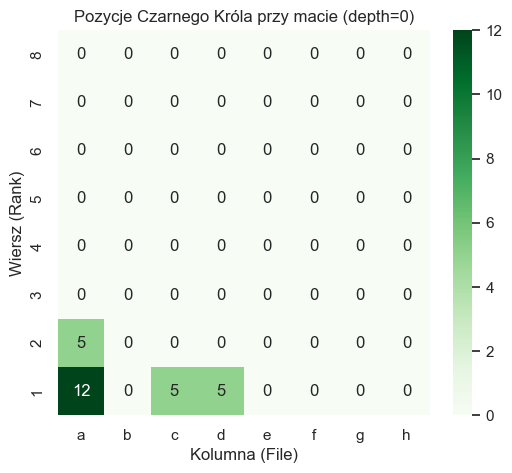

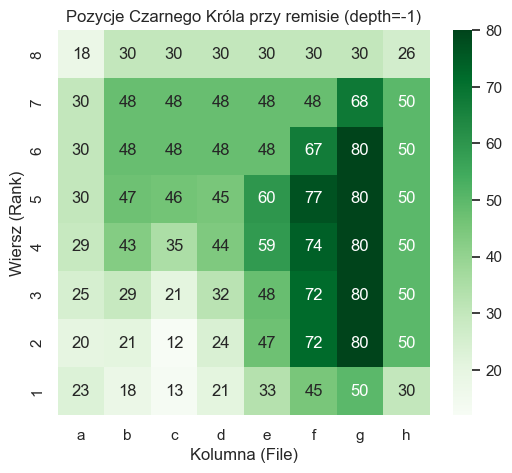

In [24]:
def plot_king_heatmap(data, title):
    # macierz 8x8 na której będziemy zluicza pozycje czarnego króla przy macie
    heatmap_data = np.zeros((8, 8))
    for _, row in data.iterrows():
        # -1 żeby idx były od zero (w szachach jest od 1)
        x = int(row['black_king_file']) - 1
        y = int(row['black_king_rank']) - 1
        heatmap_data[y, x] += 1 # y to wiersz,  x kolumna

    plt.figure(figsize=(6, 5))
    sns.heatmap(heatmap_data, annot=True, fmt='g', cmap='Greens',
                xticklabels=['a','b','c','d','e','f','g','h'],
                yticklabels=[1,2,3,4,5,6,7,8])
    plt.gca().invert_yaxis() 
    plt.title(title)
    plt.xlabel("Kolumna (File)")
    plt.ylabel("Wiersz (Rank)")
    plt.show()

# pozycje mata (depth=0)
mate_df = df[df['white_depth_of_win'] == 0]
plot_king_heatmap(mate_df, "Pozycje Czarnego Króla przy macie (depth=0)")

# pozycje remisu (depth=-1)
draw_df = df[df['white_depth_of_win'] == -1]
plot_king_heatmap(draw_df, "Pozycje Czarnego Króla przy remisie (depth=-1)")

Odp.:
Dla mata:
Na wykresie widzimy, że czarny król znajduje się wyłącznie na polach a1, a2, c1 oraz d1, czyli na krawędzi lub w rogu (wiersz 1 i kolumna a). Wartości w środku planszy (np. e5) wynoszą 0.
Wniosek: Mat jest możliwy wtedy i tylko wtedy, gdy czarny król zostanie zepchnięty do krawędzi planszy.

Dlaczego tylko lewy dolny róg? Wynika to ze struktury zbioru danych UCI. Dane są zredukowane o pozycje symetryczne (obroty i odbicia planszy), aby biały król zawsze znajdował się w określonej ćwiartce. W "rzeczywistej" grze maty występowałyby we wszystkich 4 rogach i na wszystkich 4 krawędziach, ale matematycznie są one równoważne pozycjom pokazanym na wykresie.

Dla remisu:
Rozkład pozycji jest znacznie bardziej rozproszony niż w przypadku mata. Czarny król może znajdować się niemal wszędzie. Widoczne jest silne skupisko w obszarze kolumn 'f' i 'g' oraz wierszy od 5 do 7.

Wniosek: Remis w końcówce Król + Wieża vs Król (przy optymalnej grze) rzadko wynika z pozycji "patowej" w rogu (bo białe grając optymalnie do niej nie dopuszczą), a częściej z sytuacji, w których:

Czarny król jest w stanie zbijać niechronioną wieżę.
Układ figur uniemożliwia białym zrobienie postępu (specyficzne ustawienie królów względem siebie).

Fakt, że "gorący obszar" (hotspot) jest przesunięty w prawy górny rejon (f-g), jest lustrzanym odbiciem pozycji białego króla (który w tym zbiorze danych jest pozycjonowany w dolnych rejonach ze względu na redukcję symetrii).

**Pytanie 2**
Jaka metryka dystansu (Euklidesowa, Manhattan, lub Czebyszewa) pomiędzy nimi pozwoli najlepiej oszacować liczbę ruchów do zakończenia gry?

Korelacja z liczbą ruchów do wygranej:
white_depth_of_win    1.000000
dist_euclidean        0.290681
dist_manhattan        0.296696
dist_chebyshev        0.266009
Name: white_depth_of_win, dtype: float64


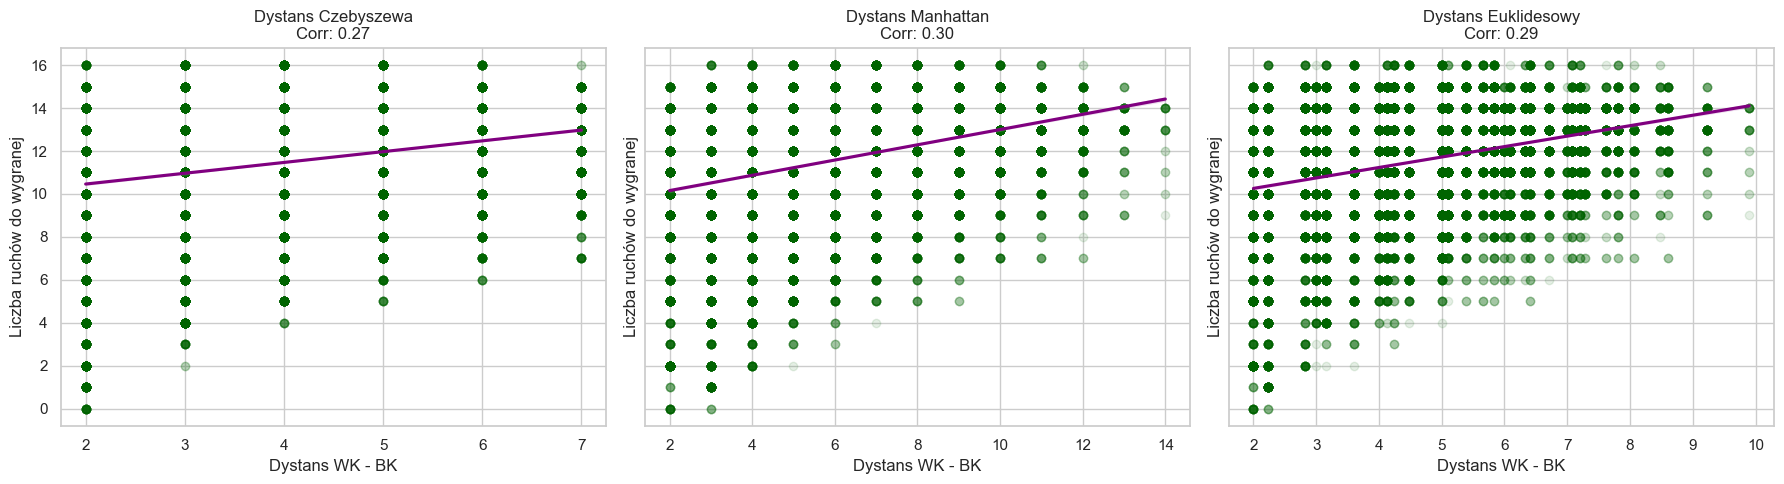

In [25]:
# dane bez remisów remisy
df_clean = df[df['white_depth_of_win'] != -1].copy()

# obliczamy korelacje Pearsona dla metryk
correlations = df_clean[['white_depth_of_win', 'dist_euclidean', 'dist_manhattan', 'dist_chebyshev']].corr()
print("Korelacja z liczbą ruchów do wygranej:")
print(correlations['white_depth_of_win'])

# wykres korelacji
fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharey=True)

metrics = ['dist_chebyshev', 'dist_manhattan', 'dist_euclidean']
titles = ['Dystans Czebyszewa', 'Dystans Manhattan', 'Dystans Euklidesowy']

for ax, metric, title in zip(axes, metrics, titles):
    sns.regplot(x=metric, y='white_depth_of_win', data=df_clean, ax=ax,
                scatter_kws={'alpha':0.1, 'color':'darkgreen'}, line_kws={'color':'purple'})
    ax.set_title(f"{title}\nCorr: {df_clean[metric].corr(df_clean['white_depth_of_win']):.2f}")
    ax.set_xlabel("Dystans WK - BK")
    ax.set_ylabel("Liczba ruchów do wygranej")

plt.tight_layout()
plt.show()

Odp.:
Wyniki dla wszystkich 3 metryk były bardzo zbliżone, ale najlepszą metryką okazała się metryka Manhattan (korelacja 0.30), wyprzedzając nieznacznie Euklidesową (0.29) i Czebyszewa (0.27).

**Pytanie 3**
Czy informacja o odległości czarnego króla od krawędzi planszy może być przydatna w określeniu w ilu ruchach zakończy się gra? Czy uzupełnienie tej informacji o odległość pomiędzy białym a czarnym królem z poprzedniego zadania może dodatkowo pomóc?

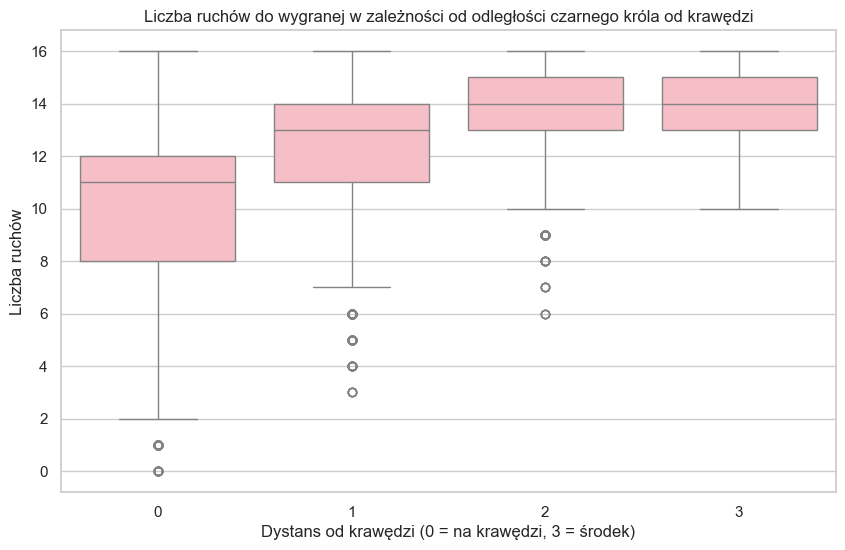

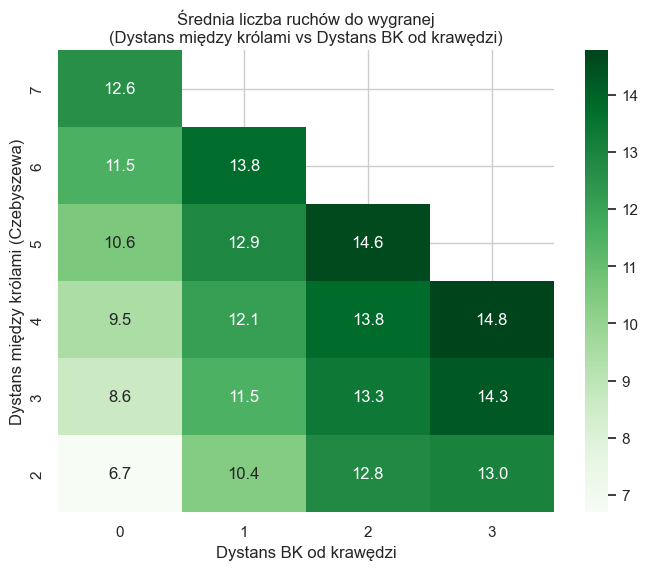

In [26]:
# boxplot - odległość od krawędzi a liczba ruchów do mata
# 1. Wykres pudełkowy: Odległość od krawędzi vs Liczba ruchów
plt.figure(figsize=(10, 6))
sns.boxplot(x='bk_edge_dist', y='white_depth_of_win', data=df_clean, color="lightpink")
plt.title("Liczba ruchów do wygranej w zależności od odległości czarnego króla od krawędzi")
plt.xlabel("Dystans od krawędzi (0 = na krawędzi, 3 = środek)")
plt.ylabel("Liczba ruchów")
plt.show()

# heatmapa - uzupełniona o odległość między królami
pivot_table = df_clean.pivot_table(
    values='white_depth_of_win',
    index='dist_chebyshev',
    columns='bk_edge_dist',
    aggfunc='mean'
)

plt.figure(figsize=(8, 6))
sns.heatmap(pivot_table, annot=True, fmt=".1f", cmap="Greens")
plt.title("Średnia liczba ruchów do wygranej\n(Dystans między królami vs Dystans BK od krawędzi)")
plt.xlabel("Dystans BK od krawędzi")
plt.ylabel("Dystans między królami (Czebyszewa)")
plt.gca().invert_yaxis()
plt.show()

Czy informacja o odległości czarnego króla od krawędzi jest przydatna? 
Tak. Wykres pudełkowy pokazuje tę zależność:

Im bliżej krawędzi jest czarny król, tym szybciej kończy się gra.
Gdy król stoi na bandzie (dystans 0), mediana ruchów wynosi ok. 11. Gdy stoi na środku (dystans 3), wzrasta do ok. 14 ruchów.

Czy dodanie odległości między królami pomaga? Tak. Mapa ciepła precyzuje tę ocenę:

Tak, nie tylko odległość czarnego króla od krawędzi ma znaczenie, ale ważne jest też, gdzie stoi biały król.

Najszybszy mat (średnio 6.7 ruchu) występuje wtedy, gdy czarny król jest na krawędzi i jednocześnie biały król jest blisko niego (odległość 2 w metryce Czebyszewa).

Gdy czarny król jest na środku planszy (odległość 3 od krawędzi), nawet to, że biały król jest blisko nie gwarantuje szybkiej wygranej (średnio aż 13 ruchów), bo najpierw trzeba go zepchnąć do krawędzi.